# Mixture of 3 (concentric) circles
### Notebook

--- 

In [1]:
import Pkg
Pkg.activate("/storage/home/suv87/work/julia/ra-hmc")

  Activating project at `~/work/julia/ra-hmc`


In [2]:
using main
using Distributions, BenchmarkTools, Plots, Pipe, ProgressMeter
using Random, LinearAlgebra, Setfield, StatsBase
using Optim, Zygote, ForwardDiff

gr(fmt=:png, levels=5, lw=0.5, msa=0.1, msw=0.5, ma=0.2, msc=:firebrick1, legend=:topright)
ProgressMeter.ijulia_behavior(:clear);

---

## Model

$
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pA}[1]{\Big(#1\Big)}
\newcommand{\q}{\boldsymbol{q}}
\newcommand{\zerov}{\boldsymbol{0}}
$

$$
\pi(\q) \propto \sum\limits_{i=1}^3 \phi\pA{\norm{\q}_p - r_i \  | \  \zerov, \sigma}
$$

where $\phi(\cdot | \mu, \sigma)$ is the PDF $\mathcal{N}(\zerov, \sigma^2)$

In [3]:
params = (; r1=4.0, r2=8.0, r3=12.0, s=0.25, p=1)

(r1 = 4.0, r2 = 8.0, r3 = 12.0, s = 0.25, p = 1)

In [4]:
# function make_model(d; r1=2.0, r2=4.0, s=0.25, m=9.0)
function make_model(d; r1=2.0, r2=4.0, r3=6.0, s=0.25, p=2)
    σ = (s)^(d / 2)
    F(x) = sum([pdf(Normal(0.0, σ), norm(x, p) - r) for r in [r1; r2; r3]])
    f(x) = max(F(x), floatmin(Float64))
    U(x) = min(-log(f(x)), floatmax(Float64))
    mod = Model(
        ξ=MvNormal(d, 1.0),
        d=d,
        f=x -> f(x),
        g=x -> Zygote.gradient(x_ -> Zygote.forwarddiff(f, x_), x),
        U=x -> min(-log(f(x)), floatmax(Float64)),
        # dU=x -> Zygote.gradient(x_ -> Zygote.forwarddiff(U, x_), x)[1],
        dU=x -> Zygote.gradient(U, x)[1],
    )
    return mod
end


function scatterplot(x; 
        baseplt=plot(0,0,label=""), 
        label="", ma=0.05, cb=false,
        c=cgrad(:viridis, 3, categorical=true), 
        kwargs...)
    
    plt_lim = (-params.r3, params.r3) .* 1.1
    
    if typeof(x) <: Tuple
        marker_size = exp.(2 .* standardize(UnitRangeTransform, x[2]))
        nrm = norm.(eachrow(x[1]), params.p)
        cl = map(x -> x < params.r2 - 4 * params.s ? c[1] : (x < params.r3 - 4 * params.s ? c[2] : c[3]), nrm)        
        
        plt = plot(baseplt, x[1] |> m2t, c=:black, lw=0.1, la=0.2, label="", lim=plt_lim, ratio=1)
        plt = scatter(plt, x[1] |> m2t, ms=marker_size, c = cl, ma=ma, label=label, cb=cb; kwargs...)
    else
        
        nrm = norm.(eachrow(x), params.p)
        cl = map(x -> x < params.r2 - 4 * params.s ? c[1] : (x < params.r3 - 4 * params.s ? c[2] : c[3]), nrm)        
        
        plt = plot(baseplt, x |> m2t, c=:black, lw=0.1, la=0.2, label="", lim=plt_lim, ratio=1)
        plt = scatter(plt, x |> m2t, c = cl, ma=ma, label=label, cb=cb; kwargs...)
    end
    return plt
end


function acfplot(x, p=1; kwargs...)
    if typeof(x) <: Tuple
        return plot(norm.(eachrow(x[1]), p); kwargs...)
    else
        return plot(norm.(eachrow(x), p); kwargs...)
    end
end

function sample_spheres(n, d; r1=2.0, r2=4.0, r3=6.0, s=0.25, p=2)
    n *= 2
    R = [r1; r2; r3]
    r = sample(R, weights(R.^(d-1)), n, replace=true) .+ rand(Normal(0.0, s), n)
    # r = sample(R, n, replace=true) .+ rand(Normal(0.0, s), n)
    X = randn(n, d)
    X = X ./ norm.(eachrow(X), p)
    return X .* r
end

function w2(X)
    if typeof(X) <: Tuple
        n, d = size(X[1])
        Z = sample_spheres(n, d; params...)
        return W2(X[1], Z, X[2] ./ sum(X[2]))
    else
        Z = sample_spheres(size(X)...; params...)
        return W2(X, Z)
    end
end

w2 (generic function with 1 method)

In [5]:
cls = palette(:linear_wcmr_100_45_c42_n256, 100, rev=false)
gr(levels=20, lw=0.5, msa=0.1, msw=0.5, ma=0.2, msc=:firebrick1, legend=:topright)
ProgressMeter.ijulia_behavior(:clear);

plt(; lim=(-14, 14), kwargs...) = contourf(
    repeat([range(lim..., length=200)], 2)...,
    (x, y) -> model.f([x, y]) ^ 0.2,
    c=cls
    ; kwargs...
)

plt (generic function with 1 method)

---

# $d = 2$

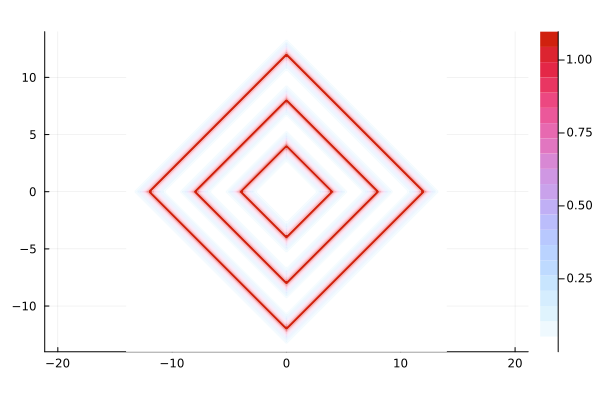

In [6]:
model = make_model(2; params...);

plt(ratio=1)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
  HMC(0.33430367316064413, 27, Any[]):  0.29374125174965005


Acceptance Ratio = 0.2937
 38.007575 seconds (102.57 M allocations: 5.141 GiB, 3.55% gc time, 66.62% compilation time: 0% of which was recompilation)


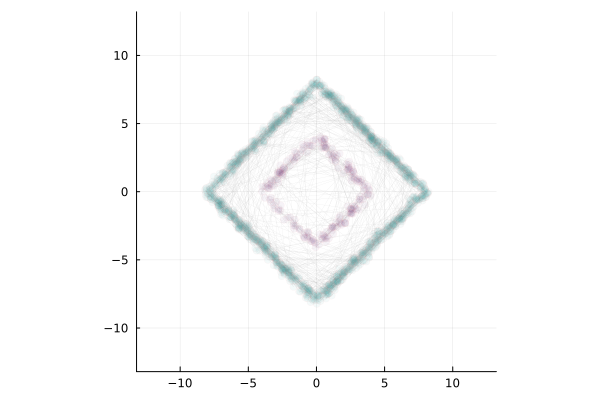

In [7]:
@time s1, a1 = mcmc(
    DualAverage(λ=9.0, δ=0.65),
    HMC(),
    model; n=5e3, n_burn=1e3
)
x_hmc = s1[a1, :];
x_hmc |> scatterplot

Progress: 100%|█████████████████████████████████████████| Time: 0:01:28
  RAHMC(0.09026552964765283, 100, 0.245276487038529, Any[]):  0.6318736252749451


Acceptance Ratio = 0.6319
 88.754738 seconds (496.24 M allocations: 24.524 GiB, 6.67% gc time, 1.04% compilation time)


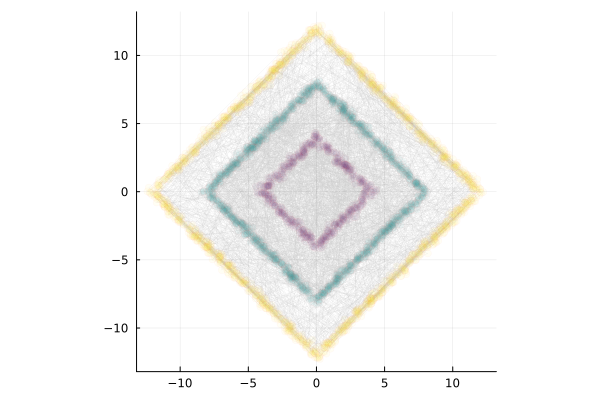

In [8]:
@time s2, a2 = mcmc(
    DualAverage(λ=9.0, δ=0.65),
    RAHMC(),
    model; n=5e3, n_burn=1e3
)
x_rahmc = s2[a2, :];
x_rahmc |> scatterplot

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(ZeroMeanIsoNormal(
dim: 2
μ: Zeros(2)
Σ: [1.0 0.0; 0.0 1.0]
)
, [0.20257653165560763, -0.8136204689582076], Any[]):       0.44225962339610064


Acceptance Ratio = 0.4384
  1.064971 seconds (2.49 M allocations: 136.468 MiB, 3.37% gc time, 92.45% compilation time)


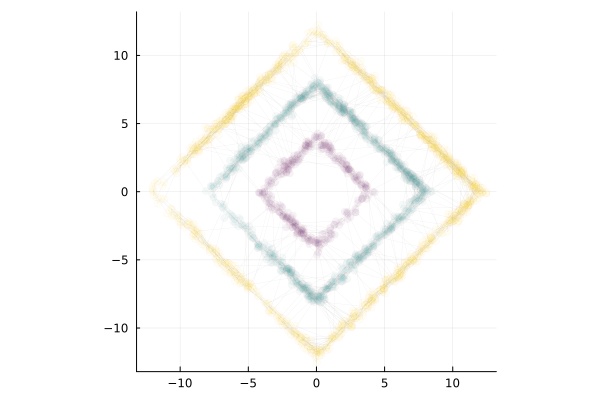

In [9]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 1.0), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_ram = s3[a3, :];
x_ram |> scatterplot

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
  PEHMC:  0.8543046357615894


Acceptance Ratio = 0.8462
 63.324061 seconds (461.49 M allocations: 17.939 GiB, 5.08% gc time, 10.37% compilation time)


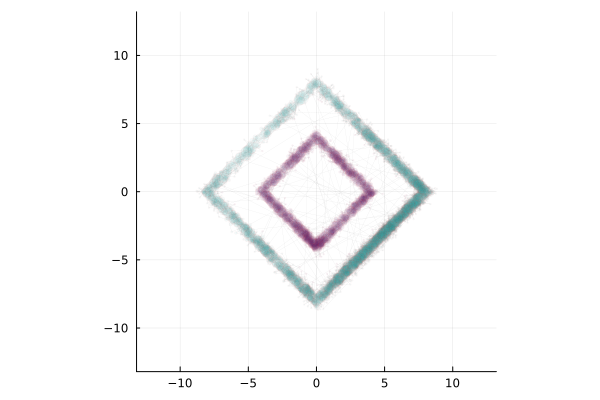

In [10]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.05, L=20, N=100),
    model; n=5e1, n_burn=1e2
)
x_pehmc, w_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...];
(x_pehmc, w_pehmc) |> scatterplot

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
  WHMC:  0.600359856057577


Acceptance Ratio = 0.6004
 24.119749 seconds (103.31 M allocations: 4.967 GiB, 4.91% gc time, 49.71% compilation time: 2% of which was recompilation)


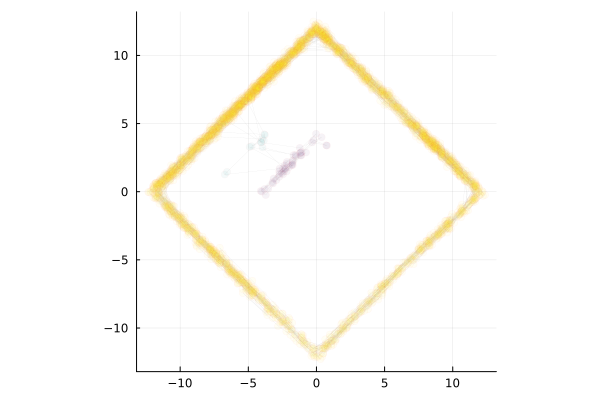

In [11]:
whmc_opt = WHMCOpt(method=LBFGS(), max_iter=100_000, temp=1.1)

@time s5, a5 = mcmc(
    WHMC(opt=whmc_opt, ϵ=0.2, L=10, k=1000), 
    model,
    n = 5e3, n_burn=1e3
)
x_whmc = s5[a5, :];
x_whmc |> scatterplot

In [12]:
var_names = ["hmc", "rahmc", "ram", "pehmc", "whmc"]
xs2d = [x_hmc, x_rahmc, x_ram, (x_pehmc, w_pehmc), x_whmc]
names = ["HMC" "RA-HMC" "RAM" "PEHMC" "WHMC"];

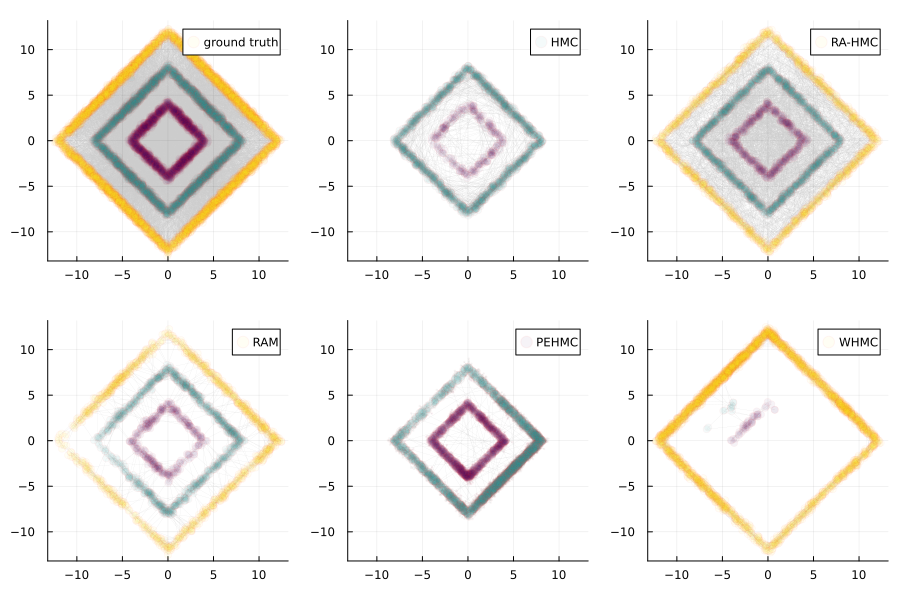

In [13]:
plot(
    scatterplot(sample_spheres(5000, 2; params...), label="ground truth", p=params.p), 
    (@pipe zip(xs2d, names) .|> scatterplot(_[1], label=_[2], p=params.p))...,
    cb=false, layout=(2, 3), size=(900, 600)
)

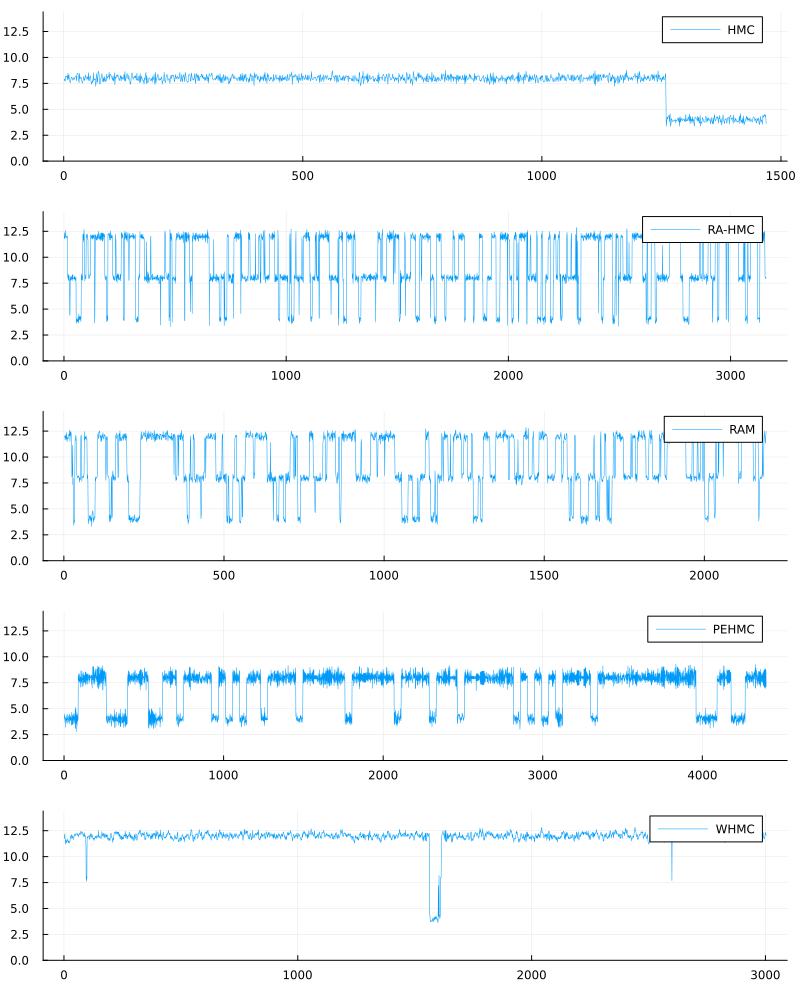

In [14]:
lims = (0.0, 1.2) .* params.r3
plot(
    (@pipe zip(xs2d, names) .|> acfplot(_[1], label=_[2]))..., 
    layout=(5, 1), size=(800, 1000), ylim=lims
)

In [15]:
w2.(xs2d)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:01:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


5-element Vector{Float64}:
 4.294857014431495
 0.19060392069427845
 0.4071330056091439
 4.417862303895281
 4.232869843587354

---

# $d = 3$

In [16]:
model = make_model(3; params...);

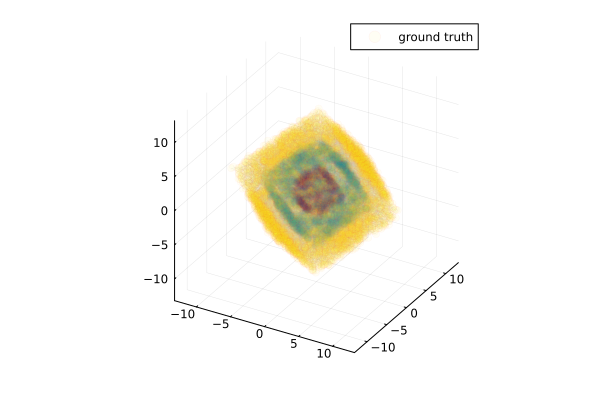

In [17]:
scatterplot(sample_spheres(5000, 3; params...), label="ground truth", p=params.p)

In [18]:
d3plot(x) = @pipe x |> plot(scatterplot(_), acfplot(_, label=""), layout=(1, 2), size=(700, 400))

d3plot (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
  HMC(0.109890369090894, 45, Any[]):  0.6724655068986203


Acceptance Ratio = 0.6725
 20.671969 seconds (112.43 M allocations: 5.546 GiB, 5.89% gc time)


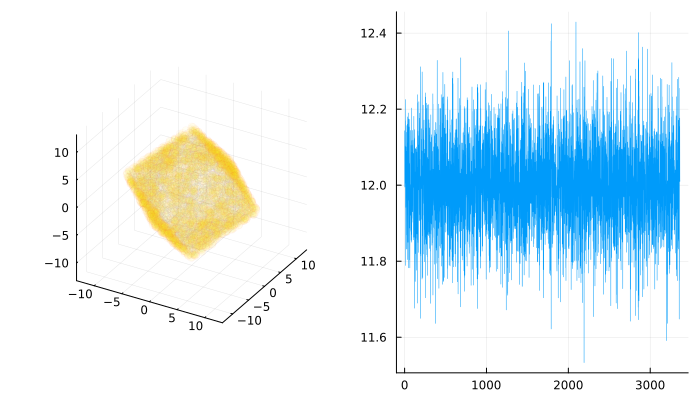

In [19]:
@time s1, a1 = mcmc(
    DualAverage(λ=5.0, δ=0.65),
    HMC(),
    model; n=5e3, n_burn=1e3
)
x_hmc_3d = s1[a1, :];
x_hmc_3d |> d3plot

Progress: 100%|█████████████████████████████████████████| Time: 0:07:38
  RAHMC(0.023507973159976995, 510, 0.2649542824784878, Any[]):  0.5282943411317736


Acceptance Ratio = 0.5283
458.651304 seconds (2.50 G allocations: 123.602 GiB, 5.55% gc time)


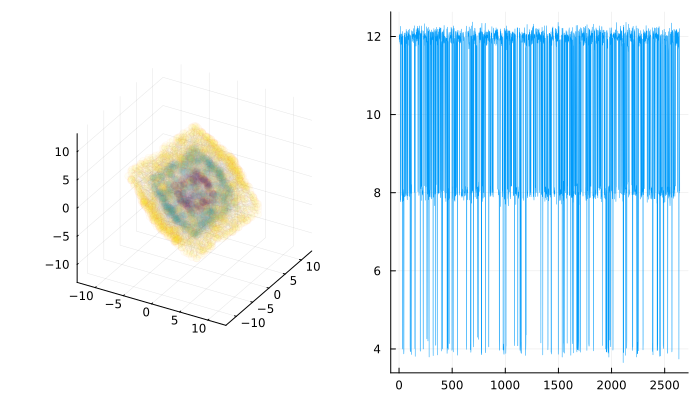

In [21]:
@time s2, a2 = mcmc(
    DualAverage(λ=12.0, δ=0.65),
    RAHMC(), 
    model; n=5e3, n_burn=1e3
)
x_rahmc_3d = s2[a2, :];
x_rahmc_3d |> d3plot

Acceptance Ratio = 0.2793
  0.132595 seconds (775.61 k allocations: 46.444 MiB, 38.35% gc time)


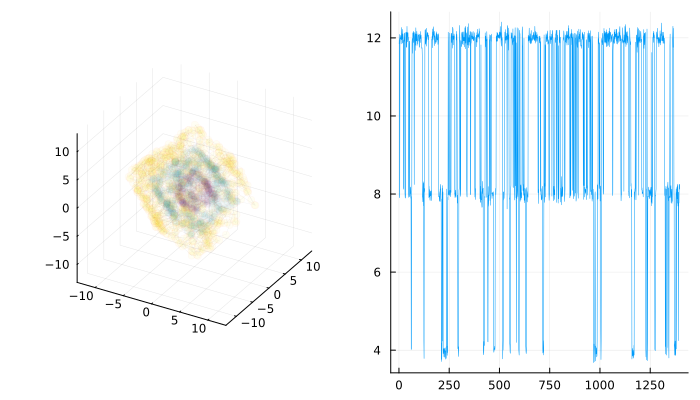

In [22]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 1.0), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_ram_3d = s3[a3, :];
x_ram_3d |> d3plot

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
  PEHMC:  0.8407960199004975


Acceptance Ratio = 0.7941
 16.602225 seconds (113.69 M allocations: 4.390 GiB, 4.99% gc time)


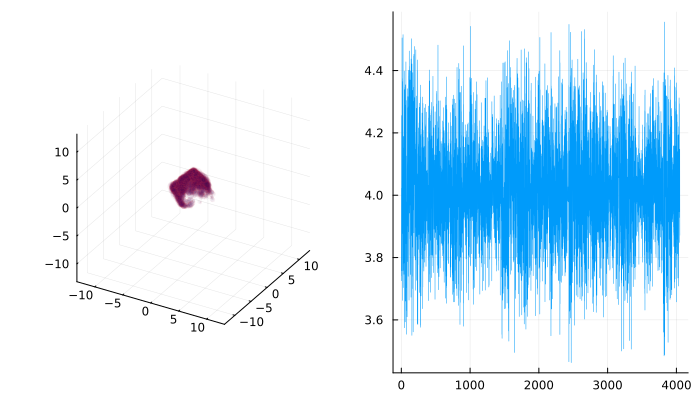

In [23]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.033, L=7, N=50),
    model; n = 1e2, n_burn=1e2
)

x_pehmc_3d, w_pehmc_3d = [s4[a4, :]...] |> a2m, [w4[a4, :]...];
(x_pehmc_3d, w_pehmc_3d) |> d3plot

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30
  WHMC:  0.8610555777688924


Acceptance Ratio = 0.8611
 30.074655 seconds (160.68 M allocations: 7.478 GiB, 4.85% gc time)


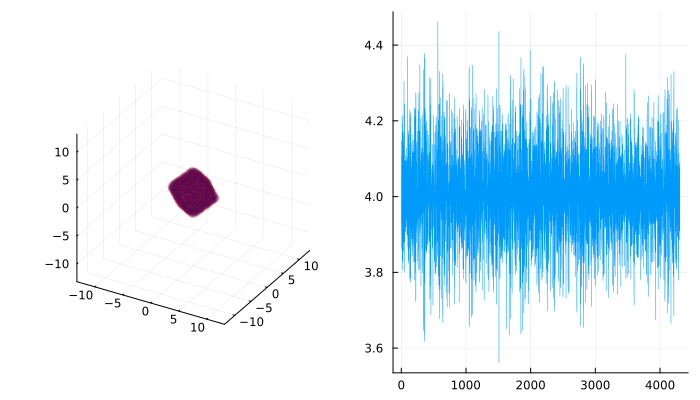

In [26]:
@time s5, a5 = mcmc(
    WHMC(opt=whmc_opt, ϵ=0.075, L=20),
    model; n = 5e3, n_burn=1e3
)
x_whmc_3d = s5[a5, :];
@pipe x_whmc_3d |> d3plot

In [27]:
xs3d = [x_hmc_3d, x_rahmc_3d, x_ram_3d, (x_pehmc_3d, w_pehmc_3d), x_whmc_3d];

In [28]:
w2.(xs3d)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:28
Progress: 100%|█████████████████████████████████████████| Time: 0:01:48


5-element Vector{Float64}:
  3.7812091934644663
  0.6468819387083307
  1.6179975733603875
 21.640350380224703
 19.696342118338872

---